In [1]:
from mlem.api import load
from mlem.runtime.client import HTTPClient
import numpy as np
from mlem.runtime.client import ExecutionError

client = HTTPClient(host="https://art-expert-.fly.dev", port=None)

In [3]:
from glob import glob

In [2]:
client

HTTPClient(interface_cache=InterfaceDescriptor(__root__={'predict': InterfaceMethod(name='predict', args=[InterfaceArgument(data_type=NumpyNdarrayType(value=None, shape=(None, 653, 4), dtype='float32'), serializer=PILImageSerializer(format='jpeg'), name='data', required=True, default=None)], returns=InterfaceDataType(data_type=DictType(value=None, item_types={'price': NumpyNumberType(value=None, dtype='float32')}), serializer=DictSerializer()))}), raw=False, host='https://art-expert-fastapi.fly.dev', port=None)

In [15]:
import pandas as pd

test = pd.read_csv("../data/artDataset/artDataset.csv")
test.price = test.price.map(lambda x: int(x[:-4].replace(".", "")))

In [50]:
%%time

y_true = []
y_pred = []
broken = []

for i, row in test.head(100).iterrows():
    y_true.append(row.price)
    img_path = f"../data/artDataset/artDataset/image_{i+1}.png"
    try:
        res = client.predict(img_path)
    except ExecutionError as e:
        y_pred.append(np.nan)
        print("E", end="")
        broken.append((e.msg, row))
    else:
        y_pred.append(res["price"])
        print(".", end="")

print()
for b in broken:
    print(b)

................E...................................................................................
('ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(1, 219, 224, 3)', Unnamed: 0                                                     16
price                                                        5000
artist                                               Anne Appleby
title                                                  Cottonwood
yearCreation                                                 2012
signed                                         Signed lower right
condition       This work is in excellent condition, direct fr...
period                                               Contemporary
movement                                               Minimalism
Name: 16, dtype: object)
CPU times: user 1.4 s, sys: 276 ms, total: 1.68 s
Wall time: 2min 43s


In [51]:
def rmsle(y_true, y_pred):
    return np.nanmean((np.log10(y_true) - np.log10(y_pred)) ** 2) ** 0.5

rmsle(y_true, y_pred)

/var/folders/tv/l60j0x050p536g3bh8g2w1n80000gn/T/ipykernel_62235/3268028309.py:2: RuntimeWarning: invalid value encountered in log10
  return np.nanmean((np.log10(y_true) - np.log10(y_pred)) ** 2) ** 0.5


1.2384911801012037

/Users/aguschin/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


<Axes: ylabel='Frequency'>

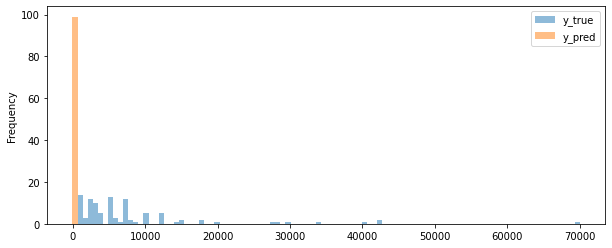

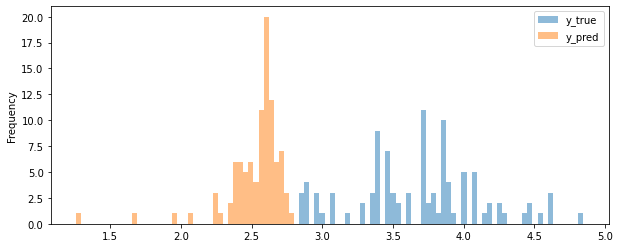

In [49]:
preds = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
kwargs = dict(kind="hist", bins=100, alpha=0.5, figsize=(10, 4))
preds.plot(**kwargs)
np.log10(preds).plot(**kwargs)